In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import os
import gc

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white')

In [3]:
wd_dir = '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_microglia/GSE171266'
os.chdir(wd_dir)


In [4]:
# Load WT data (GSM5221533)
adata_wt = sc.read_10x_mtx(
    './data/GSM5221533_1',  
    var_names='gene_symbols',
    cache=True
)
adata_wt.var_names_make_unique()
adata_wt.obs['sample'] = 'WT_D686D'

# Load Mutant data (GSM5221534)
adata_mut = sc.read_10x_mtx(
    './data/GSM5221534_2',  
    var_names='gene_symbols',
    cache=True
)
adata_mut.var_names_make_unique()
adata_mut.obs['sample'] = 'Mut_D868N'

# Concatenate the datasets
adata = adata_wt.concatenate(adata_mut, join='outer')

... reading from cache file cache/data-GSM5221533_1-matrix.h5ad


... reading from cache file cache/data-GSM5221534_2-matrix.h5ad


/beegfs/scratch/tmp/ipykernel_42015/3341626474.py:20: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_wt.concatenate(adata_mut, join='outer')


In [5]:
gc.collect()

496

In [6]:
adata

AnnData object with n_obs × n_vars = 20384640 × 36601
    obs: 'sample', 'batch'
    var: 'gene_ids', 'feature_types'

In [7]:
# Save the data
adata.write_h5ad('./output/GSE171266.h5ad', compression='lzf')
gc.collect()


0

In [8]:
# Load the data back
adata = sc.read_h5ad('./output/GSE171266.h5ad')
gc.collect()

12

In [9]:
# Calculate quality control metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)

# Filter cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
gc.collect()

filtered out 20226945 cells that have less than 200 genes expressed
filtered out 13049 genes that are detected in less than 3 cells


321

In [10]:
# Filter cells based on mitochondrial gene content
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)
adata = adata[adata.obs.pct_counts_mt < 20]
gc.collect()

0

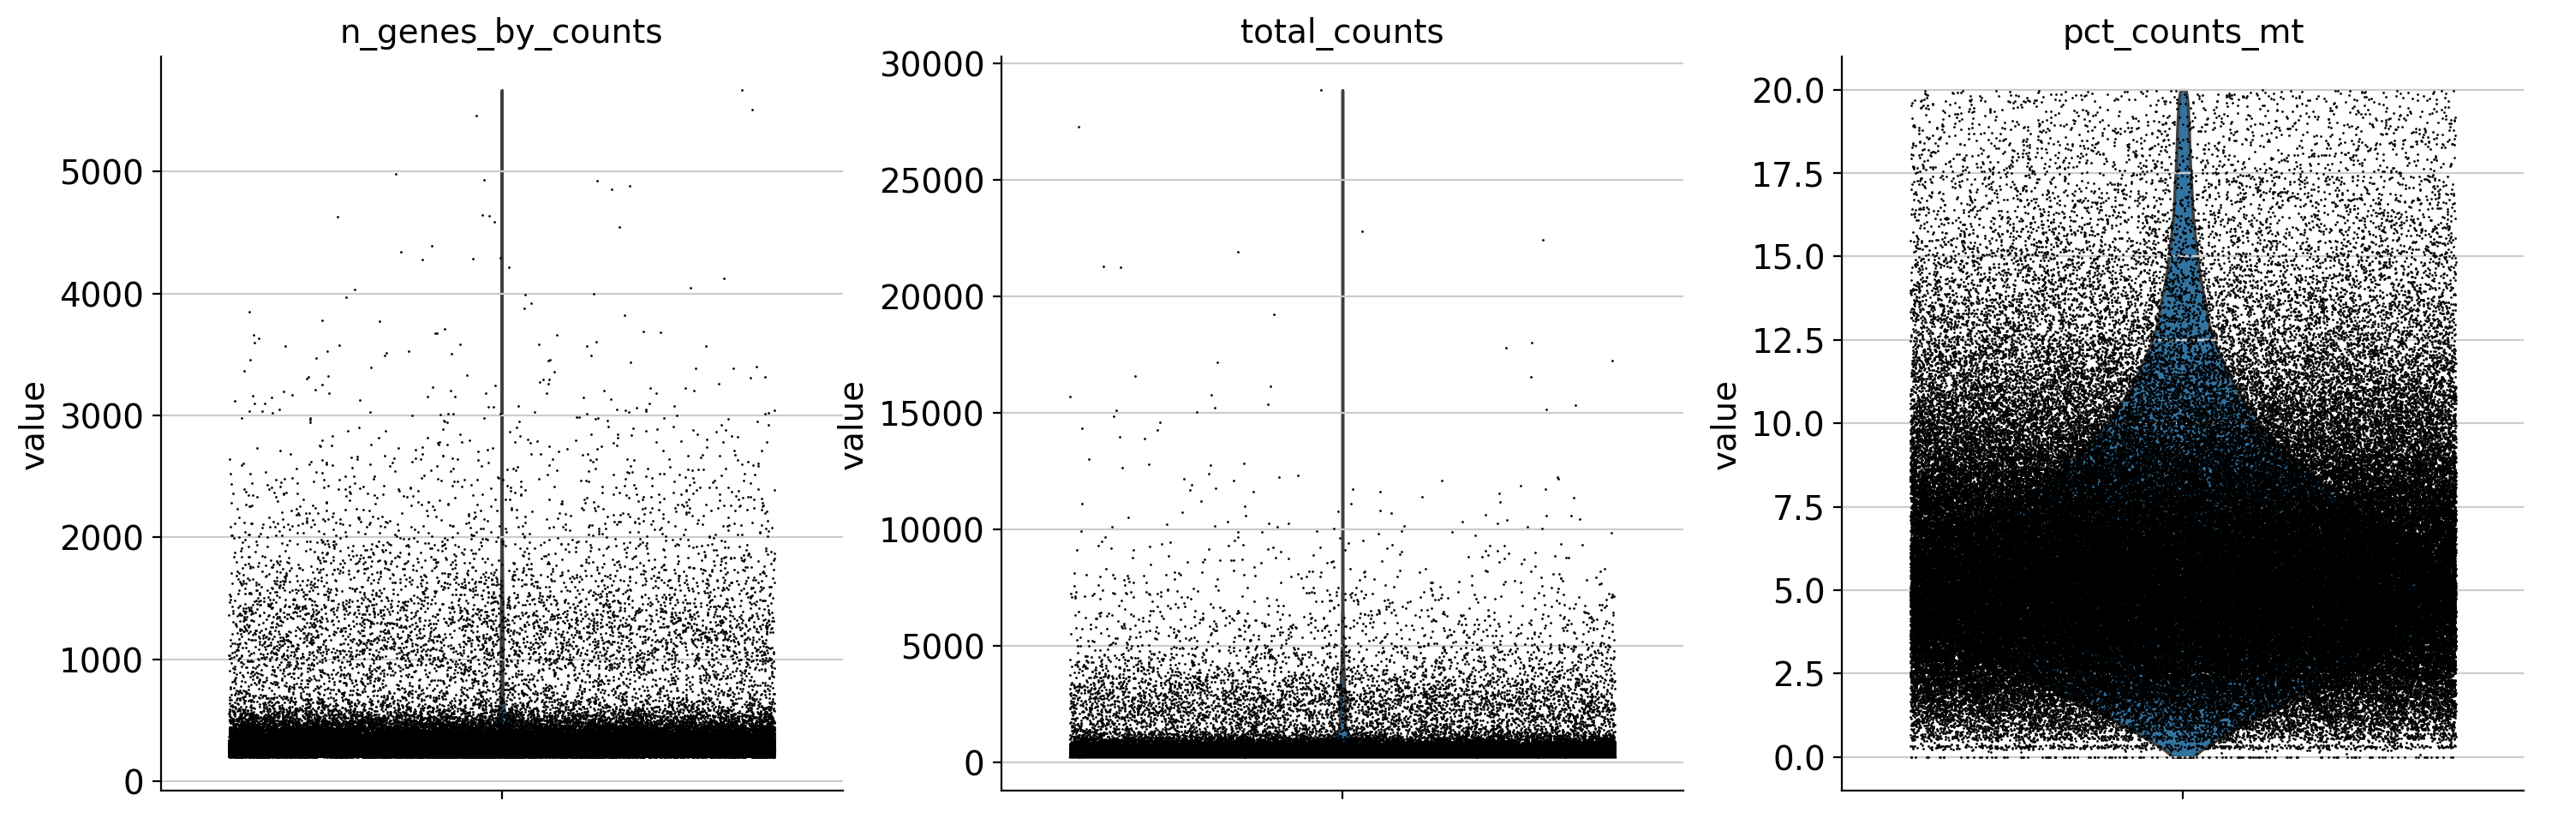

384

In [11]:
# Plot quality metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
gc.collect()

In [12]:
# Filter cells based on QC metrics (adjust these thresholds as needed)
adata = adata[adata.obs.n_genes_by_counts < 3000, :]
adata = adata[adata.obs.total_counts < 10000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]
gc.collect()

9454

In [13]:
adata

View of AnnData object with n_obs × n_vars = 154843 × 23552
    obs: 'sample', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt'

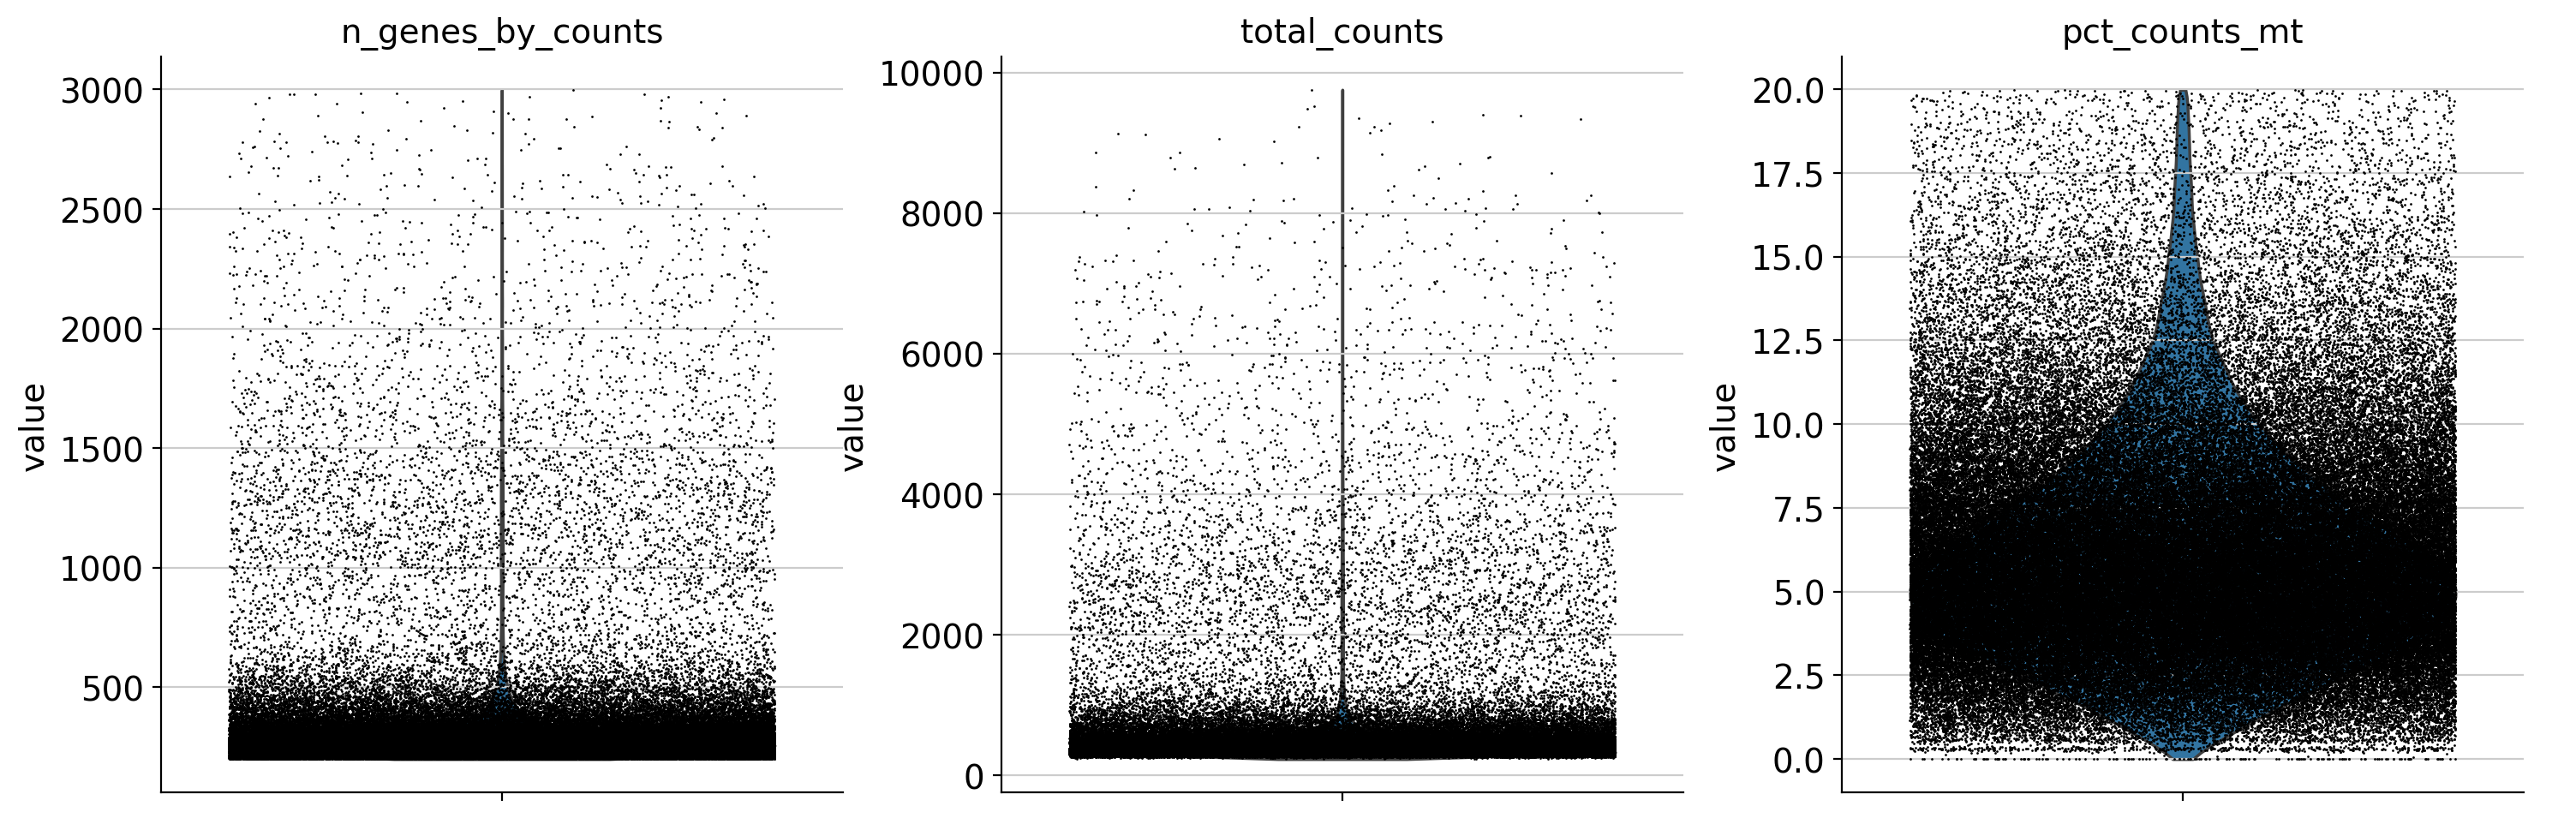

378

In [14]:
# Plot quality metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
gc.collect()

In [15]:
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
gc.collect()

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


8630

In [16]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
gc.collect()

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


0

In [17]:
# Scale the data
sc.pp.scale(adata, max_value=10)
gc.collect()

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


7

In [18]:
# Run PCA
sc.tl.pca(adata, svd_solver='arpack')
gc.collect()

computing PCA
    with n_comps=50
    finished (0:00:14)


99

In [19]:
# Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
gc.collect()

# Run UMAP
sc.tl.umap(adata)
gc.collect()

# Perform clustering
sc.tl.leiden(adata)
gc.collect()

computing neighbors
    using 'X_pca' with n_pcs = 40


/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:53)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:03:05)
running Leiden clustering


/beegfs/scratch/tmp/ipykernel_42015/4061544996.py:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:05:12)


0

In [20]:
# Save the AnnData
adata.write_h5ad('./output/GSE171266_processed.h5ad')
gc.collect()

0

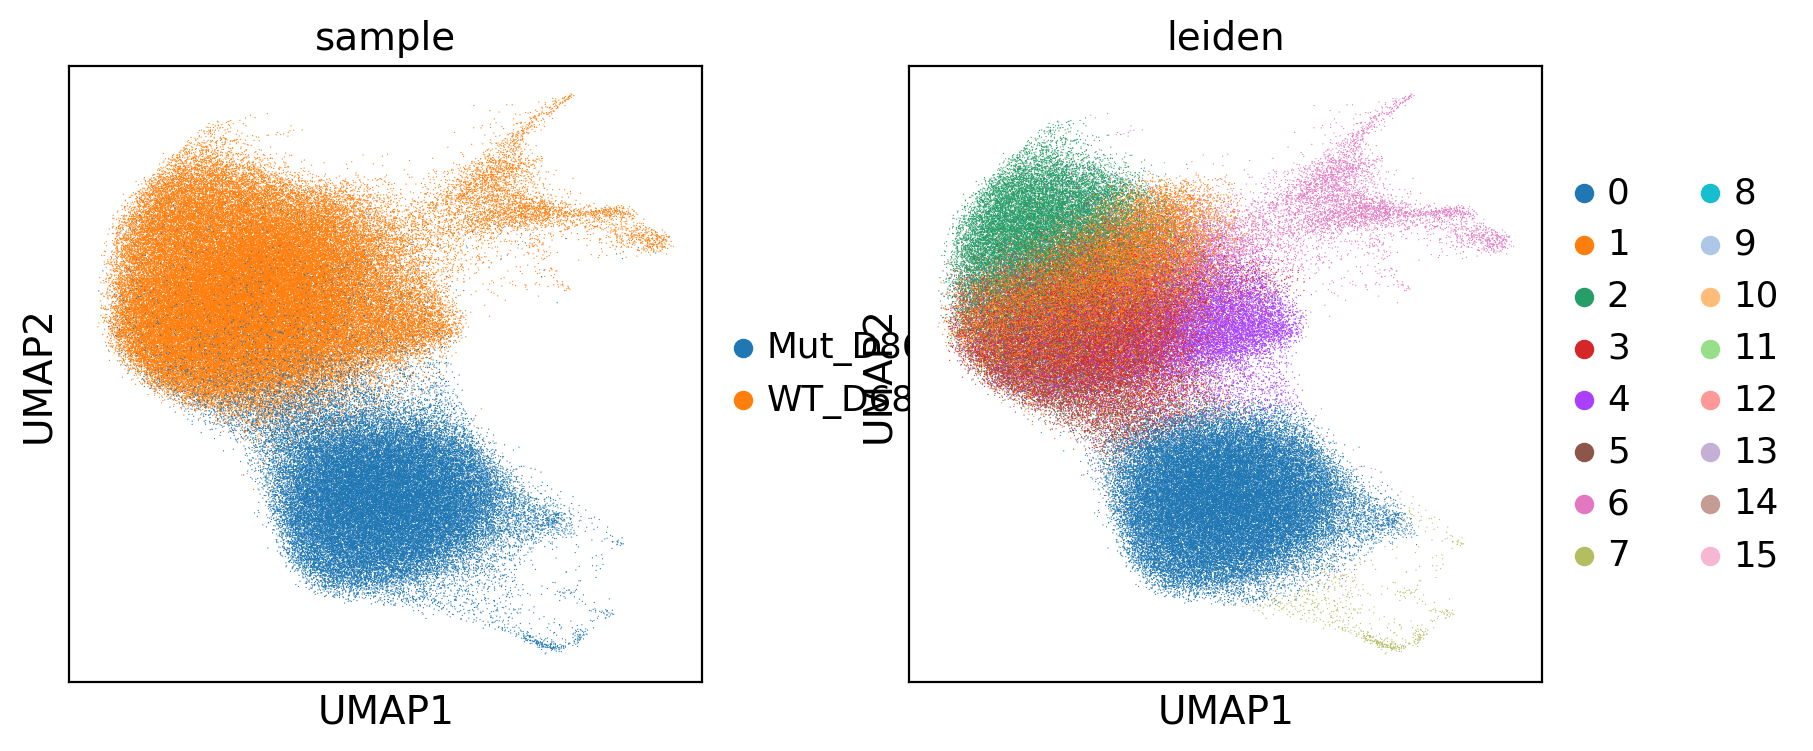

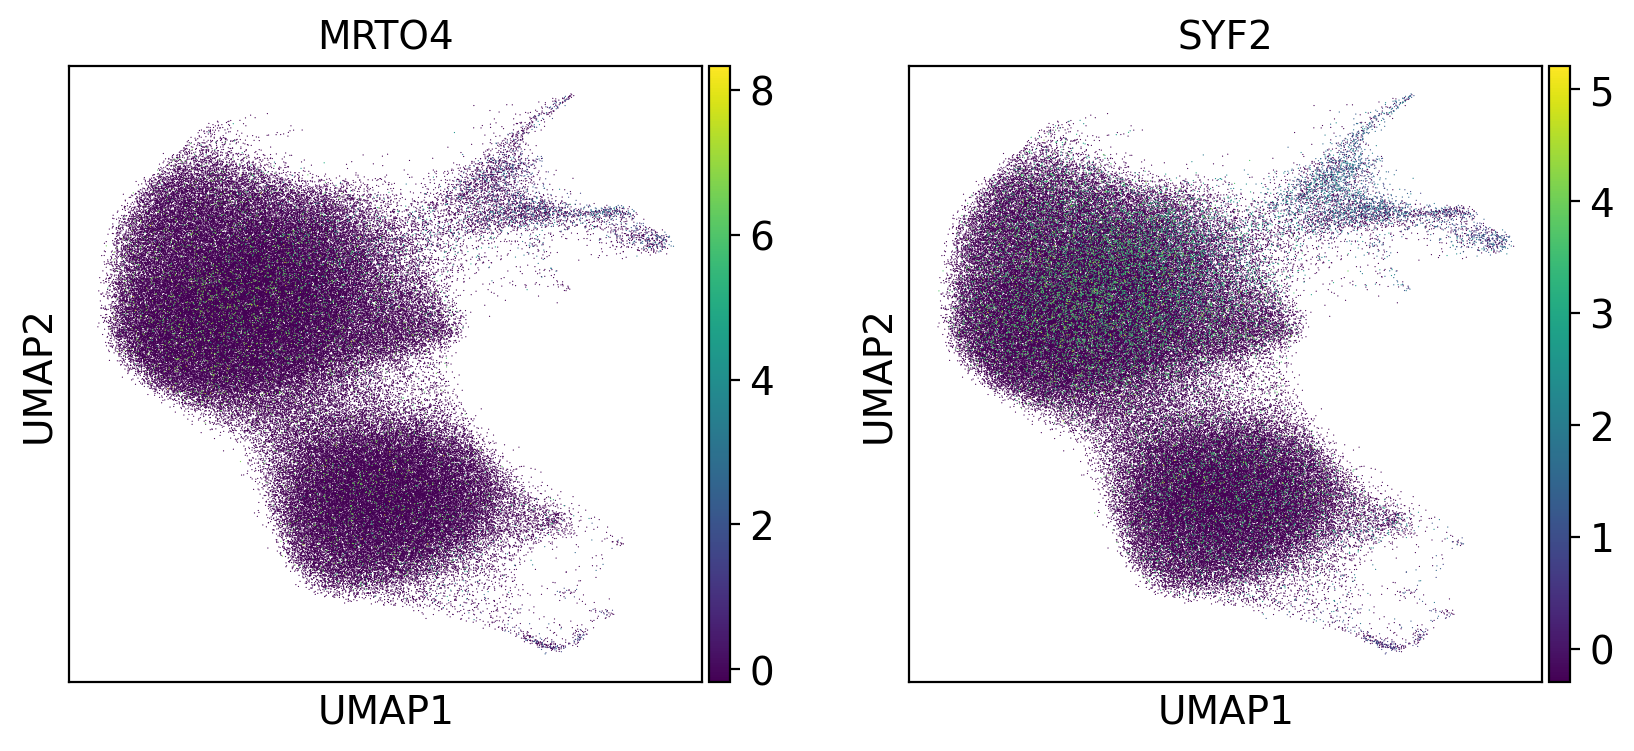

Available genes: ['MRPL20', 'HES5', 'ACOT7', 'MRTO4', 'CAMK2N1', 'ID3', 'SRRM1', 'SYF2', 'TRNP1', 'DNAJC8', 'ATP5IF1', 'SNHG12', 'ZCCHC17', 'CLSPN', 'CDCA8', 'PPIH', 'FAM183A', 'KIF2C', 'LURAP1', 'BEND5', 'ELAVL4', 'AL049637.2', 'CDKN2C', 'HSPB11', 'LRRC42', 'NFIA', 'USP1', 'ITGB3BP', 'GADD45A', 'FUBP1', 'IFI44L', 'RPF1', 'C1orf52', 'GTF2B', 'C1orf194', 'PSRC1', 'GSTM3', 'PIFO', 'DCLRE1B', 'NHLH2', 'TRIM45', 'HIST2H4B', 'HIST2H2AC', 'PLEKHO1', 'AL391069.2', 'S100A10', 'S100A11', 'S100A6', 'C1orf189', 'MEX3A', 'C1orf61', 'TSTD1', 'CFAP126', 'DUSP12', 'NUF2', 'CCDC181', 'MRPS14', 'BRINP2', 'RGS16', 'IVNS1ABP', 'HMCN1', 'C1orf53', 'LHX9', 'UBE2T', 'KLHDC8A', 'SERTAD4-AS1', 'LINC00467', 'CENPF', 'TAF1A', 'AL392172.1', 'NVL', 'CNIH4', 'ENAH', 'PARP1', 'C1orf35', 'MRPL55', 'GUK1', 'HIST3H2A', 'RNF187', 'RAB4A', 'CCSAP', 'PGBD5', 'C1orf131', 'TSNAX', 'COA6', 'TOMM20', 'ARID4B', 'GREM2', 'FH', 'EXO1', 'COX20', 'HNRNPU', 'SCCPDH', 'SNTG2', 'ADI1', 'SOX11', 'SILC1', 'ITGB1BP1', 'RRM2', 'FAM49A',

8259

In [24]:
# Plot UMAP
sc.pl.umap(adata, color=['sample', 'leiden'])
gc.collect()

# Plot gene expression
# Check if genes are present in the dataset before plotting
genes_to_plot = ['MRTO4', 'SYF2']
available_genes = [gene for gene in genes_to_plot if gene in adata.var_names]

if available_genes:
    sc.pl.umap(adata, color=available_genes)
else:
    print("None of the specified genes were found in the dataset.")

# If you want to see all available genes:
print("Available genes:", adata.var_names.tolist())

gc.collect()

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:19)


/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


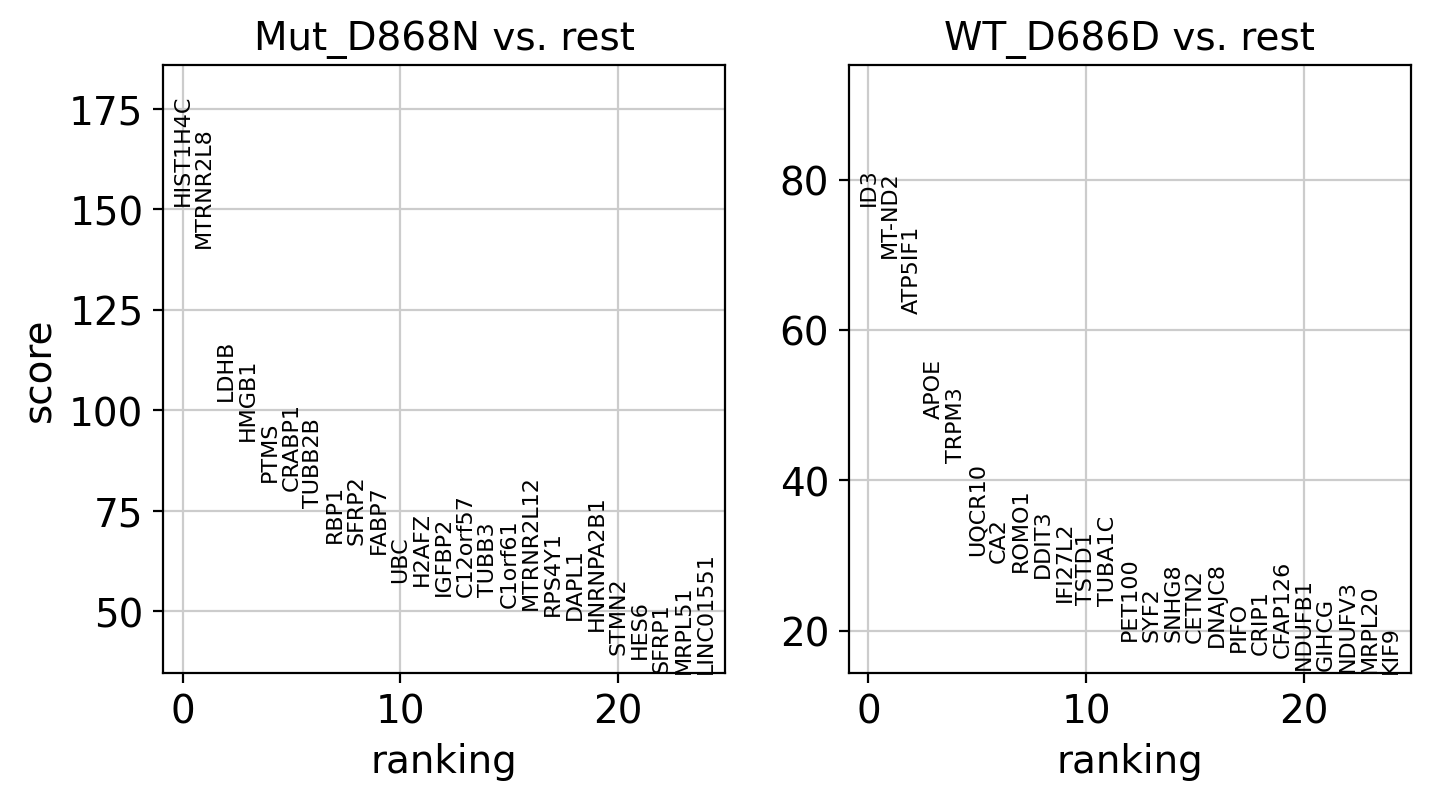

7655

In [25]:
# Find marker genes for each cluster
# sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
# gc.collect()

# Find differentially expressed genes between WT and Mutant
sc.tl.rank_genes_groups(adata, 'sample', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
gc.collect()

In [26]:
# Save the AnnData
adata.write_h5ad('./output/GSE171266_processed.h5ad')
gc.collect()


0

In [ ]:
# Load the saved AnnData object
adata_loaded = sc.read_h5ad('./output/GSE171266_processed.h5ad')
gc.collect()

In [ ]:
# # Save the processed AnnData object
# adata.write('GSE171266_processed.h5ad')

# # Save key figures
# sc.pl.umap(adata, color=['sample', 'leiden'], save='umap_sample_clusters.pdf')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save='marker_genes.pdf')

# Load bulk data

In [34]:
import os
import gzip
import pandas as pd
import numpy as np

def load_bulk_data(filename):
    try:
        with gzip.open(filename, 'rt') as f:
            # Skip the first line (comment)
            next(f)
            # Read the data, specifying column names and types
            df = pd.read_csv(f, sep='\t', header=None, 
                             names=['gene_id', 'chr', 'start', 'end', 'strand', 'length', 'count'],
                             dtype={'gene_id': str, 'chr': str, 'start': int, 'end': int, 
                                    'strand': str, 'length': int, 'count': int})
        return df.set_index('gene_id')['count']
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return None

# Load bulk RNA-seq data
bulk_samples = {
    'WT1': 'GSM4559050_WT1Aligned.sortedByCoord.out_counts.txt.gz',
    'WT2': 'GSM4559051_WT2Aligned.sortedByCoord.out_counts.txt.gz',
    'WT6': 'GSM4559052_WT6Aligned.sortedByCoord.out_counts.txt.gz',
    'LM05_1': 'GSM4559053_LM05_1Aligned.sortedByCoord.out_counts.txt.gz',
    'LM05_2': 'GSM4559054_LM05_2Aligned.sortedByCoord.out_counts.txt.gz',
    'MUT5': 'GSM4559055_MUT5Aligned.sortedByCoord.out_counts.txt.gz',
    'LM05_3': 'GSM4559056_LM05_3Aligned.sortedByCoord.out_counts.txt.gz',
    'LM05_4': 'GSM4559057_LM05_4Aligned.sortedByCoord.out_counts.txt.gz',
    'LM05_5': 'GSM4559058_LM05_5Aligned.sortedByCoord.out_counts.txt.gz'
}

data_dir = './data'
bulk_data = {}

for sample, filename in bulk_samples.items():
    file_path = os.path.join(data_dir, filename)
    sample_data = load_bulk_data(file_path)
    if sample_data is not None:
        bulk_data[sample] = sample_data

if bulk_data:
    bulk_df = pd.DataFrame(bulk_data)
    bulk_df_norm = bulk_df.apply(lambda x: x / x.sum() * 1e6)
    print("Bulk data loaded and normalized successfully.")
else:
    print("No bulk data could be loaded. Please check the data files and their locations.")

# Print the first filename to verify the change
print(os.path.join(data_dir, list(bulk_samples.values())[0]))

ValueError: invalid literal for int() with base 10: 'Start'

In [ ]:
# Get average expression per cluster in single-cell data
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
cluster_means = adata.uns['rank_genes_groups']['names'].iloc[0:100, :].apply(lambda x: np.mean(adata[:, x].X, axis=0))

# Correlate cluster means with bulk samples
correlations = cluster_means.apply(lambda x: bulk_df_norm.corrwith(x))

# Plot heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, cmap='YlGnBu', annot=True)
plt.title('Correlation between single-cell clusters and bulk samples')
plt.tight_layout()
plt.savefig('sc_bulk_correlation.pdf')
plt.close()

In [ ]:
# Get top DEGs from single-cell data
sc_degs = sc.get.rank_genes_groups_df(adata, group='Mut_D868N')
sc_degs = sc_degs[sc_degs['pvals_adj'] < 0.05].sort_values('logfoldchanges', ascending=False)

# Get DEGs from bulk data
bulk_wt = bulk_df_norm[['WT1', 'WT2', 'WT6']].mean(axis=1)
bulk_mut = bulk_df_norm[['LM05_1', 'LM05_2', 'MUT5', 'LM05_3', 'LM05_4', 'LM05_5']].mean(axis=1)
bulk_fc = np.log2(bulk_mut / bulk_wt)
bulk_degs = pd.DataFrame({'log2FoldChange': bulk_fc}).sort_values('log2FoldChange', ascending=False)

# Compare DEGs
common_degs = set(sc_degs.index) & set(bulk_degs.index)
deg_comparison = pd.DataFrame({
    'sc_log2FC': sc_degs.loc[common_degs, 'logfoldchanges'],
    'bulk_log2FC': bulk_degs.loc[common_degs, 'log2FoldChange']
})

# Plot comparison
plt.figure(figsize=(10, 10))
sns.scatterplot(data=deg_comparison, x='sc_log2FC', y='bulk_log2FC')
plt.xlabel('Single-cell log2FC')
plt.ylabel('Bulk log2FC')
plt.title('Comparison of DEGs between single-cell and bulk RNA-seq')
plt.tight_layout()
plt.savefig('deg_comparison.pdf')
plt.close()